<div style="display: flex; align-items: center; justify-content: space-between">
    <div>
        <img src="https://raw.githubusercontent.com/sebastianVP/RADAR_AMISR/refs/heads/main/igp_logo.jpeg"
         alt="LOGO IGP" width="200" height="200" style="margin-left: 20px; border-radius: 10px;" align = "right">
        <h1 style="color: #800020;  font-weight: bold; margin-bottom: 10px; font-family: Arial, sans-serif;">
          <font color="#7F000E">
            Maestría de Ciencias de la Computación UNI-IGP
          </font>
        </h1>
        <h2 style="color: #800020;font-weight: bold; max-width: 750px; font-family: Arial, sans-serif;">
          <strong><font color="#7F000E" size=5 >
            Desarrollo de sistema de pronóstico de centelleo ionosférico sobre el Perú para alerta de
            perturbaciones en señales satelitales
          </font ></strong>
        </h2>
    </div>
</div>
<div>
    <p style="margin-bottom: 5px;">
    <strong>
    <font color="#7F000E" size=3 > N1-MODULO DE PROCESAMIENTO PARA CINTILACIONES IONOFÉRICAS </strong></p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong>Alumno:</strong></font>
    <font color="#7F000E"> Alexander Valdez Portocarrero</p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong>Código:</strong> 20207072E</p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong>Fecha:</strong>  23/12/2025</p>
    <p style="margin-bottom: 5px;">
    <font color="#7F000E"><strong> Ciclo 2025-2</strong></p>
</div>

---

# **1. LIBRERIAS**

In [3]:
# =============================================================================
# MODULO DE PREPROCESAMIENTO PARA CINTILACIONES IONOSFÉRICAS
# Autor: Alexander Valdez Portocarrero
# Descripción: Carga, análisis exploratorio y preparación de tensores para LSTM
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf # Solo si necesitas verificar GPU aquí
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Importaciones específicas de Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-12-23 12:19:51.458899: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 12:19:51.728470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766510391.805871   31149 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766510391.825556   31149 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766510391.971080   31149 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# **2. CARGA DE DATOS**

In [8]:
def cargar_dataset(path, filename):
    """
    Carga el CSV y realiza la conversión inicial de fechas.
    """
    full_path = os.path.join(path, filename)
    
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"No se encontró el archivo en: {full_path}")
    
    print(f"📂 Cargando archivo: {filename}...")
    df = pd.read_csv(full_path)
    
    # Conversión única y definitiva a datetime
    df["Tiempo"] = pd.to_datetime(df["Tiempo"])
    
    # Ordenar cronológicamente (vital para series temporales)
    df = df.sort_values("Tiempo")
    
    print(f"✅ Dataset cargado. Shape: {df.shape}")
    print(f"   Rango de fechas: {df['Tiempo'].min()} a {df['Tiempo'].max()}")
    return df

# **3. ANALISIS EXPLORATORIO(EDA)**

In [11]:
def analizar_eventos_cintilacion(df, umbral_s4=0.6, plot=True):
    """
    Analiza y visualiza los días con presencia de cintilación.
    No modifica el DF original permanentemente, solo reporta estadísticas.
    """
    print("\n🔍 Analizando distribución de eventos...")
    
    # Trabajamos con una copia ligera para no alterar el original
    df_analisis = df[["Tiempo", "S4"]].copy()
    df_analisis["Fecha"] = df_analisis["Tiempo"].dt.date
    
    # 1. Identificar si cada día superó el umbral
    resumen_diario = df_analisis.groupby("Fecha")["S4"].max() > umbral_s4
    resumen_diario = resumen_diario.reset_index()
    resumen_diario.columns = ["Fecha", "Evento_Cintilacion"] # True/False
    
    total_dias = resumen_diario["Fecha"].nunique()
    dias_con_evento = resumen_diario["Evento_Cintilacion"].sum()
    
    print(f"   Total de días registrados: {total_dias}")
    print(f"   Días con eventos (S4 > {umbral_s4}): {dias_con_evento}")
    print(f"   Porcentaje de actividad: {(dias_con_evento/total_dias)*100:.2f}%")
    
    # 2. Reporte Mensual
    df_analisis["Mes"] = df_analisis["Tiempo"].dt.to_period("M")
    
    # Unimos para saber qué día tuvo evento
    # Primero agrupamos por día para saber si ESE día hubo evento
    max_s4_dia = df_analisis.groupby(["Mes", "Fecha"])["S4"].max().reset_index()
    max_s4_dia["Tuvo_Evento"] = (max_s4_dia["S4"] > umbral_s4).astype(int)
    
    # Tabla resumen
    tabla_mensual = max_s4_dia.groupby("Mes")["Tuvo_Evento"].agg(
        Dias_Con_Cintilacion='sum',
        Total_Dias='count'
    )
    tabla_mensual["Dias_Sin_Cintilacion"] = tabla_mensual["Total_Dias"] - tabla_mensual["Dias_Con_Cintilacion"]
    
    print("\n📊 Resumen Mensual de Actividad:")
    print(tabla_mensual)

    # 3. Visualización (Opcional)
    if plot:
        plt.figure(figsize=(12, 5))
        # Convertimos a string para que matplotlib no haga lío con fechas
        fechas_str = resumen_diario["Fecha"].astype(str)
        valores = resumen_diario["Evento_Cintilacion"].astype(int)
        
        plt.bar(fechas_str, valores, color=np.where(valores==1, 'orange', 'skyblue'))
        plt.title(f"Días con Cintilación (S4 > {umbral_s4})")
        plt.ylabel("Presencia (1=Sí, 0=No)")
        plt.xticks(rotation=90, fontsize=8)
        
        # Mostrar solo una etiqueta cada 7 días para no saturar
        ax = plt.gca()
        for index, label in enumerate(ax.xaxis.get_ticklabels()):
            if index % 7 != 0:
                label.set_visible(False)
                
        plt.tight_layout()
        plt.show()

# **4. FEATURE ENGINEERING**

In [18]:
# =============================================================================
# 3. INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)
# =============================================================================
def agregar_caracteristicas_temporales(df):
    """
    Agrega transformaciones cíclicas de tiempo (Seno/Coseno).
    """
    print("\n⚙️ Generando características temporales (Sin/Cos)...")
    
    # Calcular minuto del día (0–1439)
    minutos_dia = df["Tiempo"].dt.hour * 60 + df["Tiempo"].dt.minute
    periodo = 24 * 60 # 1440 minutos
    
    # Transformación
    df["Hora_Sin"] = np.sin(2 * np.pi * minutos_dia / periodo)
    df["Hora_Cos"] = np.cos(2 * np.pi * minutos_dia / periodo)
    
    return df


# **5. ESTRATEGIA DE DIVISIÓN DE DATOS -DATASPLITTING**

In [26]:

# =============================================================================
# 5. ESTRATEGIA DE DIVISIÓN DE DATOS (DATA SPLITTING)
# =============================================================================
def dividir_estratificado_por_dias(df, umbral_s4=0.6):
    """
    Divide el dataset asegurando que haya días con tormentas en Train, Val y Test.
    """
    print("\n✂️ Ejecutando división estratificada de datos...")
    
    # Trabajamos con copia para no afectar el original
    temp_df = df.copy()
    
    # Si la columna Fecha no existe (porque la borramos en el paso 4), la recuperamos del índice
    if 'Fecha' not in temp_df.columns:
        temp_df['Fecha'] = temp_df.index.date
    
    # 1. Identificar Días Activos vs Días Quietos
    resumen_diario = temp_df.groupby('Fecha')['S4'].max().reset_index()
    
    dias_activos = resumen_diario[resumen_diario['S4'] > umbral_s4]['Fecha'].values
    dias_quietos_original = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values 
    #dias_quietos = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values 

    #------ AQUI VAMOS A MODIFICAR--------#
    n_activos = len(dias_activos)
    dias_quietos = dias_quietos_original[:n_activos]
    #dias_quietos = resumen_diario[resumen_diario['S4'] <= umbral_s4]['Fecha'].values
    #--------------------------------------------------------------------------------
    
    print(f"   Total Días Activos encontrados: {len(dias_activos)}")
    print(f"   Total Días Quietos encontrados: {len(dias_quietos)}")
    
    # 2. Repartir los Días ACTIVOS (aprox 70/15/15)
    # Primero separamos Train (70%) del resto (30%)
    activos_train, activos_temp = train_test_split(dias_activos, test_size=0.3, random_state=42)
    # Luego separamos ese resto en Val (50% del resto) y Test (50% del resto)
    activos_val, activos_test = train_test_split(activos_temp, test_size=0.5, random_state=42)
    
    # 3. Repartir los Días QUIETOS (misma lógica)
    quietos_train, quietos_temp = train_test_split(dias_quietos, test_size=0.3, random_state=42)
    quietos_val, quietos_test = train_test_split(quietos_temp, test_size=0.5, random_state=42)
    
    # 4. Combinar las listas
    lista_dias_train = np.concatenate([activos_train, quietos_train])
    lista_dias_val = np.concatenate([activos_val, quietos_val])
    lista_dias_test = np.concatenate([activos_test, quietos_test])
    
    # 5. Crear los DataFrames Finales
    # Ordenamos por fecha para mantener la lógica temporal interna
    # NOTA: Usamos temp_df['Fecha'] para filtrar, pero devolvemos df (el original limpio)
    #       Para asegurar consistencia, filtramos temp_df y luego dropeamos 'Fecha' si fue agregada,
    #       o simplemente usamos el índice.
    
    # Filtrar usando las fechas
    train = temp_df[temp_df['Fecha'].isin(lista_dias_train)].sort_index()
    val = temp_df[temp_df['Fecha'].isin(lista_dias_val)].sort_index()
    test = temp_df[temp_df['Fecha'].isin(lista_dias_test)].sort_index()
    
    # Limpieza final: Si agregamos 'Fecha' temporalmente, la quitamos para dejar los datos limpios
    if 'Fecha' in train.columns:
        train = train.drop(columns=['Fecha'])
        val = val.drop(columns=['Fecha'])
        test = test.drop(columns=['Fecha'])
    
    return train, val, test

# **PRUEBA INICIAL**

📂 Cargando archivo: df_FINAL.csv...
✅ Dataset cargado. Shape: (204396, 13)
   Rango de fechas: 2025-01-26 00:35:00 a 2025-06-25 23:00:00

🔍 Analizando distribución de eventos...
   Total de días registrados: 148
   Días con eventos (S4 > 0.6): 29
   Porcentaje de actividad: 19.59%

📊 Resumen Mensual de Actividad:
         Dias_Con_Cintilacion  Total_Dias  Dias_Sin_Cintilacion
Mes                                                            
2025-01                     3           6                     3
2025-02                    14          26                    12
2025-03                    10          31                    21
2025-04                     2          29                    27
2025-05                     0          31                    31
2025-06                     0          25                    25


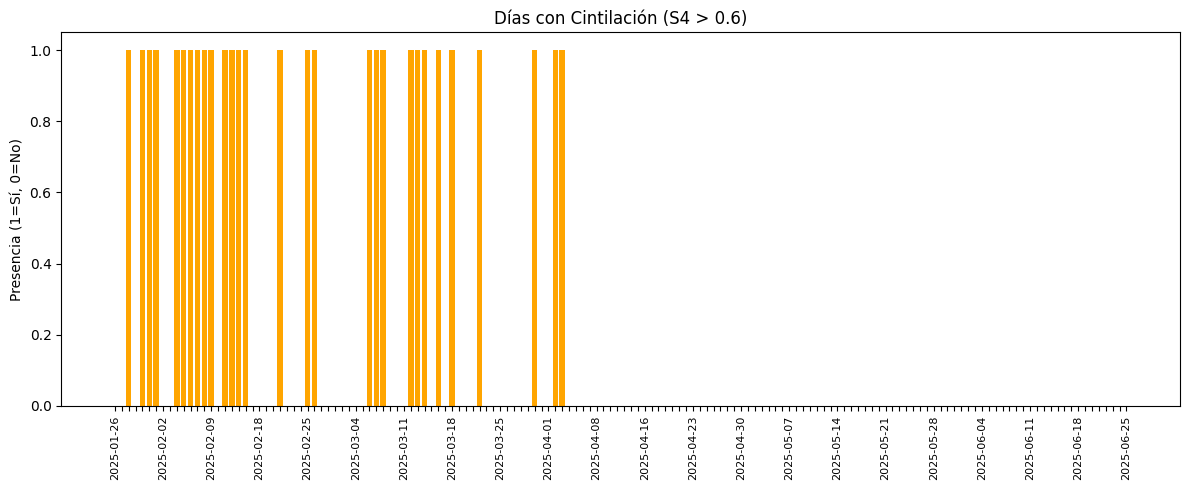


⚙️ Generando características temporales (Sin/Cos)...


In [20]:
if __name__ == "__main__":
    
    # 1. Configuración
    RUTA = "/home/soporte/Documents/CENTELLEO_INOSFERICO_DAML_PERU/notebook"
    ARCHIVO = "df_FINAL.csv"

    # Definición de Features para el modelo (Orden Importante)
    FEATURES_COLS = [
        'S4', 'TEC', 'ROTI', 'Kp_Index', 'Dst_Index', 'AE_Index', 'f10.7_Index', 
        'Hora_Sin', 'Hora_Cos'
    ]
    
    # Parámetros Temporales
    LOOKBACK_MIN = 60
    HORIZON_MIN  = 10
    
    # 2. Pipeline de ejecución
    # Cargar
    df_raw = cargar_dataset(RUTA, ARCHIVO)
    
    # Analizar (No modifica df_raw)
    analizar_eventos_cintilacion(df_raw, umbral_s4=0.6, plot=True)

    # Ingeniería de Features (Modifica df_raw)
    df_features = agregar_caracteristicas_temporales(df_raw)

In [22]:
df_features

,Tiempo,Cintilacion,Azimuth,Elevacion,TEC,ROTEC,ROTI,Kp_Index,Dst_Index,ap_Index,f10.7_Index,AE_Index,S4,Hora_Sin,Hora_Cos
0,2025-01-26 00:35:00,0.0,189.0,31.0,69.258790,-0.020608,0.010838,3.0,-1.416667,2.0,165.4,29.083333,0.161,0.152123,0.988362
1,2025-01-26 00:36:00,0.0,189.0,32.0,68.826191,-0.019268,0.010848,3.0,-1.400000,2.0,165.4,29.000000,0.122,0.156434,0.987688
2,2025-01-26 00:37:00,0.0,197.0,32.0,68.393592,-0.017928,0.010858,3.0,-1.383333,2.0,165.4,28.916667,0.128,0.160743,0.986996
3,2025-01-26 00:38:00,0.0,189.0,33.0,67.960993,-0.016589,0.010867,3.0,-1.366667,2.0,165.4,28.833333,0.106,0.165048,0.986286
4,2025-01-26 00:39:00,0.0,196.0,32.0,67.528394,-0.015249,0.010877,3.0,-1.350000,2.0,165.4,28.750000,0.103,0.169350,0.985556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204391,2025-06-25 22:56:00,0.0,180.0,54.0,60.029780,-0.004785,0.001948,47.0,-27.600000,39.0,120.7,9999.000000,0.092,-0.275637,0.961262
204392,2025-06-25 22:57:00,0.0,184.0,42.0,60.029780,-0.004785,0.001948,47.0,-27.700000,39.0,120.7,9999.000000,0.113,-0.271440,0.962455
204393,2025-06-25 22:58:00,0.0,184.0,41.0,60.029780,-0.004785,0.001948,47.0,-27.800000,39.0,120.7,9999.000000,0.098,-0.267238,0.963630
204394,2025-06-25 22:59:00,0.0,183.0,41.0,60.029780,-0.004785,0.001948,47.0,-27.900000,39.0,120.7,9999.000000,0.092,-0.263031,0.964787
